# Decision Trees

## 1. Import Libraries

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import class_weight
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import hashlib
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline

## 2. Import and pre-process the dataset

In [8]:
data = pd.read_csv('./Data/onlinefraud.csv')
data = data.drop(["nameOrig", "nameDest"], axis=1)

# Convert the 'type' attribute to a numerical one
data["type"] = data["type"].map({"CASH_OUT": 1, "PAYMENT": 2, "CASH_IN": 3, "TRANSFER": 4, "DEBIT": 5})

# Shuffle the data randomly
data = data.sample(frac=1, random_state=42)

# Set the target variable (y) and input features (X)
target_variable = 'isFraud'
input_features = [col for col in data.columns if col != target_variable]

# Determine the proportions for train, test, and validation sets
train_ratio = 0.8
test_ratio = 0.1
validation_ratio = 0.1

# Split the data into train, test, and validation sets
train_data, remaining_data = train_test_split(data, test_size=1 - train_ratio, random_state=42)
test_data, validation_data = train_test_split(remaining_data, test_size=validation_ratio / (test_ratio + validation_ratio), random_state=42)

# Set the y and X values for train, test, and validation sets
y_train = train_data[target_variable]
X_train = train_data[input_features]

y_test = test_data[target_variable]
X_test = test_data[input_features]

y_validation = validation_data[target_variable]
X_validation = validation_data[input_features]

# Verify the shapes of the resulting sets
print("Train set shapes - X:", X_train.shape, "y:", y_train.shape)
print("Test set shapes - X:", X_test.shape, "y:", y_test.shape)
print("Validation set shapes - X:", X_validation.shape, "y:", y_validation.shape)

Train set shapes - X: (5090096, 8) y: (5090096,)
Test set shapes - X: (636262, 8) y: (636262,)
Validation set shapes - X: (636262, 8) y: (636262,)


In [9]:
# Calculate the class balance for the target variable
class_balance = data['isFraud'].value_counts(normalize=True)

# Display the class balance
print("Class Balance:")
print(class_balance)

Class Balance:
isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


In [10]:
# Create an instance of SMOTE
smote = SMOTE(random_state=42, sampling_strategy=0.2)

# Apply SMOTE to the train set
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Calculate the class balance for the resampled train set
class_balance_resampled = pd.Series(y_train_resampled).value_counts(normalize=True)

# Display the class balance for the resampled train set
print("Class Balance (Resampled Train Set):")
print(class_balance_resampled)

Class Balance (Resampled Train Set):
isFraud
0    0.833333
1    0.166667
Name: proportion, dtype: float64


In [11]:
# Calculate the value counts for the test set
class_counts_test = y_test.value_counts()

# Display the value counts for the test set
print("Value Counts (Test Set):")
print(class_counts_test)

# Calculate the value counts for the validation set
class_counts_validation = y_validation.value_counts()

# Display the value counts for the validation set
print("Value Counts (Validation Set):")
print(class_counts_validation)

Value Counts (Test Set):
isFraud
0    635420
1       842
Name: count, dtype: int64
Value Counts (Validation Set):
isFraud
0    635429
1       833
Name: count, dtype: int64


## 3. Models

### 3A. Basic Decision Tree Model using SMOTE

In [12]:
# Create a decision tree classifier
clf = DecisionTreeClassifier()

# Fit the classifier on the train set
clf.fit(X_train_resampled, y_train_resampled)

# Predict on the train set
y_train_pred = clf.predict(X_train_resampled)

# Predict on the test set
y_test_pred = clf.predict(X_test)

# Predict on the validation set
y_validation_pred = clf.predict(X_validation)

In [13]:
# Calculate the classification report and confusion matrix for the train set
train_report = classification_report(y_train_resampled, y_train_pred)
train_confusion = confusion_matrix(y_train_resampled, y_train_pred)

# Calculate the classification report and confusion matrix for the test set
test_report = classification_report(y_test, y_test_pred)
test_confusion = confusion_matrix(y_test, y_test_pred)

# Calculate the classification report and confusion matrix for the validation set
validation_report = classification_report(y_validation, y_validation_pred)
validation_confusion = confusion_matrix(y_validation, y_validation_pred)

# Display the classification report and confusion matrix for the train set
print("Train Classification Report:")
print(train_report)
print("Train Confusion Matrix:")
print(train_confusion)

# Display the classification report and confusion matrix for the test set
print("Test Classification Report:")
print(test_report)
print("Test Confusion Matrix:")
print(test_confusion)

# Display the classification report and confusion matrix for the validation set
print("Validation Classification Report:")
print(validation_report)
print("Validation Confusion Matrix:")
print(validation_confusion)

Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   5083558
           1       1.00      1.00      1.00   1016711

    accuracy                           1.00   6100269
   macro avg       1.00      1.00      1.00   6100269
weighted avg       1.00      1.00      1.00   6100269

Train Confusion Matrix:
[[5083558       0]
 [      0 1016711]]
Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    635420
           1       0.75      0.97      0.85       842

    accuracy                           1.00    636262
   macro avg       0.88      0.98      0.92    636262
weighted avg       1.00      1.00      1.00    636262

Test Confusion Matrix:
[[635149    271]
 [    25    817]]
Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    635429
           1       0.71  

#### Interpretation of above data

Overall, the model shows high accuracy in predicting instances of class 0 in both the train, test, and validation sets. However, it exhibits some difficulty in accurately predicting instances of class 1, especially in the test and validation sets. These results suggest that the model may benefit from further refinement or additional techniques to improve its performance on predicting instances of the minority class.

### 3B. Finding the best sampling ratio

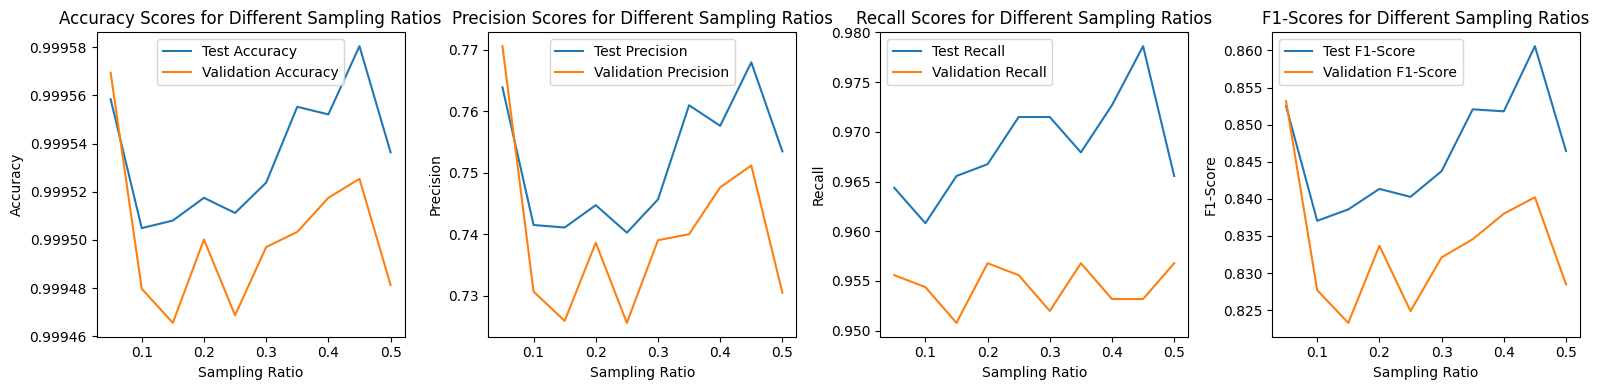

In [14]:
# Define the sampling ratios to test
sampling_ratios = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

# Initialize lists to store the performance metrics
train_accuracy_scores = []
test_accuracy_scores = []
validation_accuracy_scores = []
train_precision_scores = []
test_precision_scores = []
validation_precision_scores = []
train_recall_scores = []
test_recall_scores = []
validation_recall_scores = []
train_f1_scores = []
test_f1_scores = []
validation_f1_scores = []

# Iterate over the sampling ratios and calculate the performance metrics
for ratio in sampling_ratios:
    # Perform SMOTE on the training data
    smote = SMOTE(sampling_strategy=ratio)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Create and fit the classifier
    clf = DecisionTreeClassifier()
    clf.fit(X_train_resampled, y_train_resampled)

    # Make predictions on train, test, and validation sets
    y_train_pred = clf.predict(X_train_resampled)
    y_test_pred = clf.predict(X_test)
    y_validation_pred = clf.predict(X_validation)

    # Calculate and store the performance metrics
    train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    validation_accuracy = accuracy_score(y_validation, y_validation_pred)
    train_precision = precision_score(y_train_resampled, y_train_pred)
    test_precision = precision_score(y_test, y_test_pred)
    validation_precision = precision_score(y_validation, y_validation_pred)
    train_recall = recall_score(y_train_resampled, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)
    validation_recall = recall_score(y_validation, y_validation_pred)
    train_f1 = f1_score(y_train_resampled, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    validation_f1 = f1_score(y_validation, y_validation_pred)

    # Append the scores to the lists
    train_accuracy_scores.append(train_accuracy)
    test_accuracy_scores.append(test_accuracy)
    validation_accuracy_scores.append(validation_accuracy)
    train_precision_scores.append(train_precision)
    test_precision_scores.append(test_precision)
    validation_precision_scores.append(validation_precision)
    train_recall_scores.append(train_recall)
    test_recall_scores.append(test_recall)
    validation_recall_scores.append(validation_recall)
    train_f1_scores.append(train_f1)
    test_f1_scores.append(test_f1)
    validation_f1_scores.append(validation_f1)

# Create subplots with a row layout
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

# Plot accuracy scores

axs[0].plot(sampling_ratios, test_accuracy_scores, label='Test Accuracy')
axs[0].plot(sampling_ratios, validation_accuracy_scores, label='Validation Accuracy')
axs[0].set_xlabel('Sampling Ratio')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Accuracy Scores for Different Sampling Ratios')
axs[0].legend()

# Plot precision scores

axs[1].plot(sampling_ratios, test_precision_scores, label='Test Precision')
axs[1].plot(sampling_ratios, validation_precision_scores, label='Validation Precision')
axs[1].set_xlabel('Sampling Ratio')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision Scores for Different Sampling Ratios')
axs[1].legend()

# Plot recall scores

axs[2].plot(sampling_ratios, test_recall_scores, label='Test Recall')
axs[2].plot(sampling_ratios, validation_recall_scores, label='Validation Recall')
axs[2].set_xlabel('Sampling Ratio')
axs[2].set_ylabel('Recall')
axs[2].set_title('Recall Scores for Different Sampling Ratios')
axs[2].legend()

# Plot F1 scores

axs[3].plot(sampling_ratios, test_f1_scores, label='Test F1-Score')
axs[3].plot(sampling_ratios, validation_f1_scores, label='Validation F1-Score')
axs[3].set_xlabel('Sampling Ratio')
axs[3].set_ylabel('F1-Score')
axs[3].set_title('F1-Scores for Different Sampling Ratios')
axs[3].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

### 3C. Finding the best class weighting using the best sample ratio

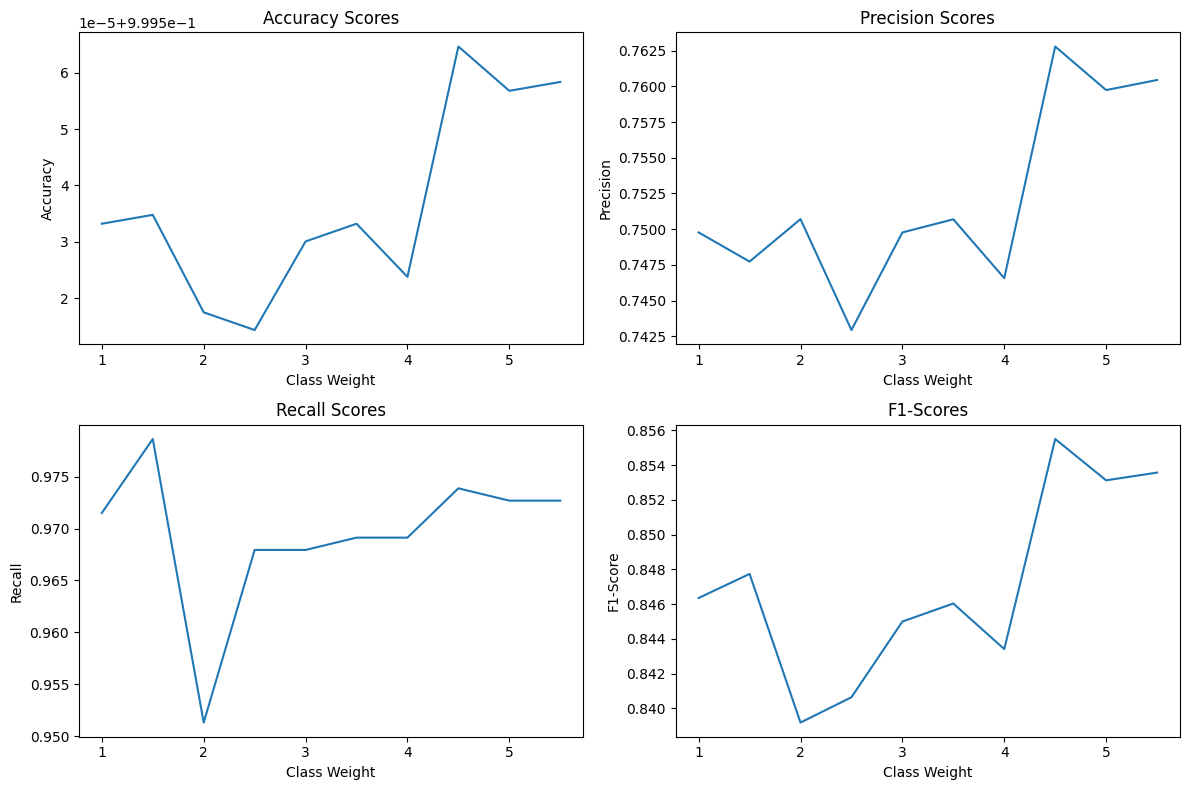

In [15]:
# Define the class weights
class_weights = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5]

# Initialize lists to store the performance metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Perform SMOTE on the training data with the optimal sampling ratio
smote = SMOTE(sampling_strategy=0.3)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Iterate over the class weights and calculate the performance metrics
for weight in class_weights:
    # Create and fit the classifier with the specified class weight
    clf = DecisionTreeClassifier(class_weight={0: 1, 1: weight})
    clf.fit(X_train_resampled, y_train_resampled)

    # Make predictions on the test set
    y_test_pred = clf.predict(X_test)

    # Calculate and store the performance metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    # Append the scores to the lists
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot accuracy scores
axs[0, 0].plot(class_weights, accuracy_scores)
axs[0, 0].set_xlabel('Class Weight')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].set_title('Accuracy Scores')

# Plot precision scores
axs[0, 1].plot(class_weights, precision_scores)
axs[0, 1].set_xlabel('Class Weight')
axs[0, 1].set_ylabel('Precision')
axs[0, 1].set_title('Precision Scores')

# Plot recall scores
axs[1, 0].plot(class_weights, recall_scores)
axs[1, 0].set_xlabel('Class Weight')
axs[1, 0].set_ylabel('Recall')
axs[1, 0].set_title('Recall Scores')

# Plot F1 scores
axs[1, 1].plot(class_weights, f1_scores)
axs[1, 1].set_xlabel('Class Weight')
axs[1, 1].set_ylabel('F1-Score')
axs[1, 1].set_title('F1-Scores')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()